# Add the lasa.py file in same directory as the jupyter notebook

In [1]:
!pip install gmr
import numpy as np
import matplotlib.pyplot as plt
from lasa import load_lasa
import gmr

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: C:\Users\sengu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Helper Functions for plotting and loading data

In [2]:
def plot_curves(x,show_start_end=True,**kwargs):
    '''
    plots 2d curves of trajectories

    params:
        x: array of shape (number of curves,n_steps_per_curve,2)
    '''
    if show_start_end:
        start_label,end_label = "start","end"
    else:
        start_label,end_label = None,None
    for t in range(x.shape[0]):
        plt.scatter(x[t][0,0],x[t][0,1],c='k',label=start_label)
        plt.scatter(x[t][-1,0],x[t][-1,1],c='b',label=end_label)
        plt.plot(x[t][:,0],x[t][:,1],**kwargs)
        if t==0:
            kwargs.pop("label",None)
            start_label,end_label = None,None

    plt.legend()


def streamplot(f,x_axis=(0,100),y_axis=(0,100),n=1000,width=1,**kwargs):
    '''
    helps visualizing the vector field.

    params:
        f: function to predict the velocities in DS(Dynamical system : x_dot = f(x),x of shape (n_points,2),x_dot of shape (n_points,2))
        x_axis: x axis limits
        y_axis: y axis limits
        n: number of points in each axis (so total n*n predictions happen)
        width: width of the vector
        **kwargs: goes into plt.streamplot
    '''
    a,b = np.linspace(x_axis[0],x_axis[1],n),np.linspace(y_axis[0],y_axis[1],n)
    X,Y = np.meshgrid(a,b)
    X_test = np.stack([X,Y],axis=-1).reshape(-1,2)
    Y_pred = f(X_test)
    U,V = np.split(Y_pred.reshape(n,n,2),2,axis=-1)
    U,V = U[...,0],V[...,0]
    speed = np.sqrt(U**2+V**2)
    lw = width*speed / speed.max()
    plt.streamplot(X,Y,U,V,linewidth=lw,**kwargs)

#gets the velocity x_dot given x
def derivative(x):
    '''
    difference method for calculating derivative

    params:
      x: array of shape (number of trajectories,number of timesteps,2)

    returns
      xd: array of shape (number of trajectories,number of timesteps,2)
    '''
    xds = []

    for i in range(x.shape[0]):
        dt = 1/(x[i].shape[0]-1)
        xd = np.vstack((np.diff(x[i], axis=0) / dt,np.zeros((1, x[i].shape[1]))))
        v_factor = np.cos(np.linspace(0,np.pi/2,len(xd)))**2
        xd = xd*(v_factor[...,None])
        xds.append(xd)
    xd = np.stack(xds)
    return xd

#loading the data and plotting
def load_data(letter):
    '''
    gets the trajectories coresponding to the given letter

    params:
      letter: character in ["c","j","s"]

    returns:
      data: array of shape (number of trajectories,number of timesteps,2)
      x: array of shape(number of trajectories*number of timesteps,2)
      xd: array of shape(number of trajectories*number of timesteps,2)

    '''
    letter2id = dict(c=2,j=6,s=24)
    assert letter.lower() in letter2id
    _,x,_,_,_,_ = load_lasa(letter2id[letter.lower()])
    xd = derivative(x)
    plot_curves(x)
    data = x
    x = x.reshape(-1,2)
    xd = xd.reshape(-1,2)
    plt.show()
    return data,x,xd

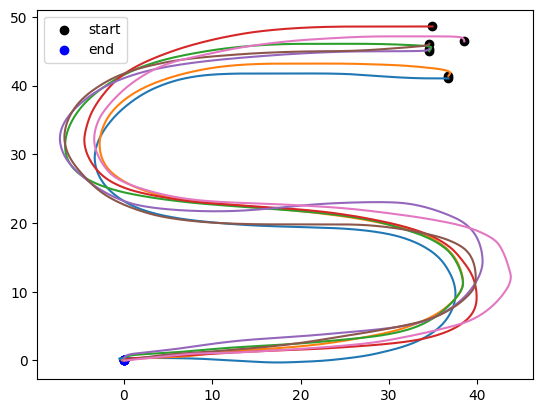

In [39]:
#letter should be one of c,j,s
# data,x,xd = load_data("j")
data,x,xd = load_data("s")
#data,x,xd = load_data("c")

# PART-1 : Linear Least Squares (LLS)

In [18]:
class LeastSquares:

    def __init__(self,lam=1e-2,bias=False):

        self.bias = bias
        self.lam = lam
    def fit(self,X,Y):
        '''
        store the weight matrix into self.w

        self.w should be array of shape (3,2) if bias is enabled and
        (2,2) if bias is False


        params:
            X: data of shape (n_points,2)
            Y: X_dot of shape(n_points,2)
        '''
        if self.bias:
            X_aug = np.hstack([X, np.ones((X.shape[0],1))])
        else:
            X_aug = X

        # Ridge regularized least squares
        I = np.eye(X_aug.shape[1])
        self.w = np.linalg.inv(X_aug.T @ X_aug + self.lam * I) @ X_aug.T @ Y



    def predict(self,X):
        '''
        returns prediction from the model X_dot

        params:
            X: array of shape (n_points,2)
        returns:
            predicted X_dot: array of shape (n_points,2)
        '''
        if self.bias:
            X_aug = np.hstack([X, np.ones((X.shape[0],1))])
        else:
            X_aug = X
        return X_aug @ self.w


    def ode_differential(self,x,t):
        '''
        function used for rk4 simulation
        '''
        return self.predict(x[None])[0]


    def rk4_sim(self,t0,t_end,x0,f,dt=1e-3):
        '''
        simlution done with rk4

        Returns
        -------
        x : shape (n_steps,self.d)
        t : shape - (n_steps,)
        '''
        # Calculate slopes
        x,t = x0,t0
        x_list,t_list = [x0],[t0]
        while t<=t_end:
            k1 = dt*f(x,t)
            k2 = dt*f(x+k1/2.,t+dt/2. )
            k3 = dt*f(x+k2/2.,t+dt/2. )
            k4 = dt*f(x+k3 , t+dt )

            # Calculate new x and y
            x = x + 1./6*(k1+2*k2+2*k3+k4)
            t = t + dt
            x_list.append(x)
            t_list.append(t)

        return np.array(x_list),np.array(t_list)

    def imitate(self,x0,t_end=5):
        '''
        imitation with new starting point

        Parameters
        ----------
        x0  - starting point - shape (self.d,)

        Returns
        -------
        x_rk4 - simulated data  - shape (n_steps,self.d)
        t_rk4 - time - shape (n_steps,)
        '''
        f = self.ode_differential
        return self.rk4_sim(0,t_end,x0,f)


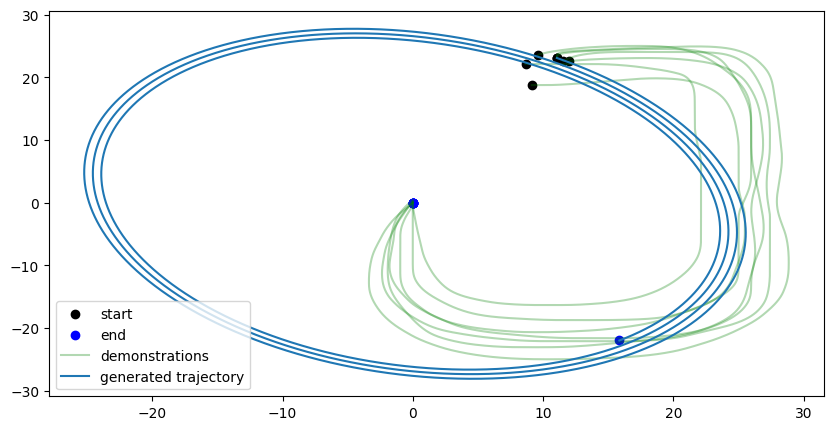

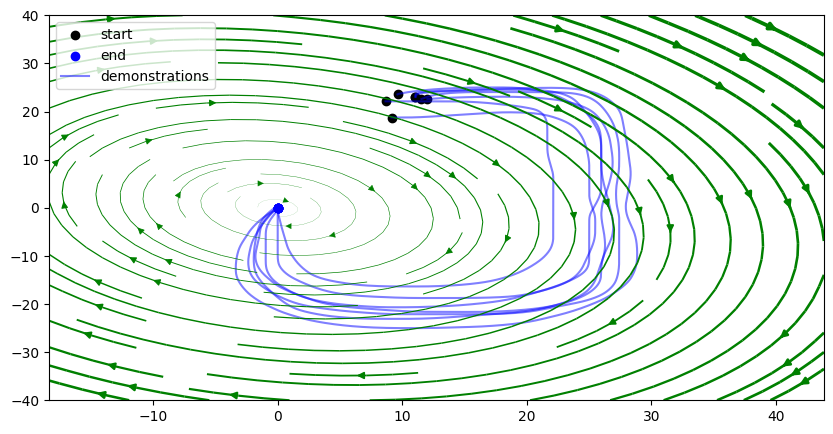

In [32]:
#fitting the model to data
model = LeastSquares(lam=0,bias=False)
model.fit(x,xd)

#starting point for imitation
x0 = data[6][0]
x_rk4,t_tk4 = model.imitate(x0,t_end=10)

#plots for generated trajectory
plt.figure(figsize=(10,5))
plot_curves(data,alpha=0.3,c="g",label="demonstrations")
plot_curves(x_rk4[None],show_start_end=False,label="generated trajectory")

#vector field plot using stream line
plt.figure(figsize=(10,5))
plot_curves(data,alpha=0.5,c="b",label="demonstrations")

streamplot(model.predict,x_axis=(min(x[:,0])-15,max(x[:,0])+15),y_axis=(min(x[:,1])-15,max(x[:,1])+15),width=3,color="g")

#Fit the model to each of the data set and answer the following questions:

**For "C" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. 
<br>
<br>
Ans: Yes. We can say the system has a GAS as we can see the trajectory genrated as well as the vector vields generated spiralling inwards towards the equilibrium from all points in the vector field.

Q2.Try changing the bias parameter to True, Report and try to explain the changes in the graph. \\
<br>
<br>
Ans: On changing the bias to True, we see the equilibrium point shift from the origin. When bias=True, the system becomes:
$$
\dot{x} = A x + b
$$
which shifts the equilibrium to:
$$
x^* = -A^{-1} b.
$$

**For "J" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
<br>
<br>
Ans:The blue trajectories form a closed orbit / limit cycle–like behavior. They do not converge to the origin. Instead, they seem to converge toward a periodic orbit. SO this sytem does not appear to have a GAS.

Q2.Try changing the bias parameter to True, Report and try to explain the changes in the graph. \\
<br><br>
Ans:
On chaning the bias to True, we see that the system now has a GAS but the vector field no longer centers at the origin. The generated trajectory (blue) spirals toward a shifted point. The origin is no longer the equilibrium.

**For "S" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
<br><br>
Ans: Yes. We can say the system has a GAS as we can see the trajectory genrated as well as the vector vields generated spiralling inwards towards the equilibrium from all points in the vector field.

Q2.Try changing the bias parameter to True, Report and try to explain the changes in the graph. \\
<br><br>
Ans:
The system still has a GAS but it has shifter. The equilibrium is no longer at origin.

In [ ]:
####################
#YOUR CODE HERE FOR ANSWERING THE ABOVE QUESTIONS
####################

# PART-2 Locally Weighted Regression (LWR)

[GMR](https://alexanderfabisch.github.io/gmr/#gmr.MVN) is handy package that helps us to deal with gaussian distributions. \\
some notable methods that you can use are *from_samples*,*to_norm_factor_and_exponents*,*condition*. \\
we can also visualize gaussians with *plot_error_ellipse* function


In [22]:
def init_gaussians(y,n=3):
    '''
    initializes the gaussian based on time fragmentaion

    params:
        y : array of shape (number of trajectories,number of timesteps,2)
    returns:
        mvns: list of gmr.MVN() initialized objects
    '''
    l = y.shape[1]//n
    y_split  = [y[:,i*l:] if i==n-1 else y[:,i*l:(i+1)*l] for i in range(n)]
    mvns = [gmr.MVN().from_samples(x.reshape(-1,2)) for x in y_split]
    splot = plt.subplot(111)
    plot_curves(y)
    for mvn in mvns:
        gmr.plot_error_ellipse(splot,mvn,factors=[1])
    return mvns

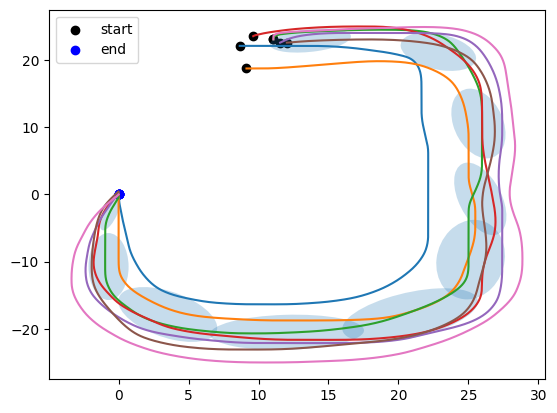

In [47]:
#basis functions initializes with gaussians from data
mvns = init_gaussians(data,10)

In [26]:
class LWR:
    def __init__(self,mvns,bias=True):
        '''
            gaussians for weights
            params:
              mvns: list of gaussians
              bias: x@weight+bias
        '''
        self.mvns = mvns
        self.bias = bias
    def fit(self,X,Y):
        '''
        gets the weight matrix into self.ws

        self.ws is a list of length len(self.mvns), with each element as weight matrix (3,2) if bias is True, (2,2) if bias is False

        params:
            X: data of shape (n_points,2)
            Y: X_dot of shape(n_points,2)
        '''
        self.ws = []
        for mvn in self.mvns:

            norm_factor, exponent = mvn.to_norm_factor_and_exponents(X)
            probs = norm_factor * np.exp(exponent)

            W = np.diag(probs)

            if self.bias:
                X_aug = np.hstack([X, np.ones((X.shape[0],1))])
            else:
                X_aug = X

            I = np.eye(X_aug.shape[1])
            A = X_aug.T @ W @ X_aug + 1e-6 * I
            B = X_aug.T @ W @ Y

            w = np.linalg.solve(A, B)
            self.ws.append(w)

    def predict(self,X):
        '''
        returns prediction from the model =>X_dot

        merge the multple predictions from different weight matrices.

        params:
            X: array of shape (n_points,2)
        returns:
            predicted X_dot: array of shape (n_points,2)
        '''
        y_pred = np.zeros((X.shape[0],2))
        weights_sum = np.zeros((X.shape[0],1))

        for mvn,w in zip(self.mvns,self.ws):

            norm_factor, exponent = mvn.to_norm_factor_and_exponents(X)
            probs = norm_factor * np.exp(exponent)
            probs = probs[:,None]

            if self.bias:
                X_aug = np.hstack([X, np.ones((X.shape[0],1))])
            else:
                X_aug = X

            y_local = X_aug @ w

            y_pred += probs * y_local
            weights_sum += probs

        return y_pred / (weights_sum + 1e-8)


    def ode_differential(self,x,t):
        '''
        function used for rk4 simulation
        '''
        return self.predict(x[None])[0]


    def rk4_sim(self,t0,t_end,x0,f,dt=1e-3):
        '''
        simlution done with rk4

        Returns
        -------
        x : shape (n_steps,self.d)
        t : shape - (n_steps,)
        '''
        # Calculate slopes
        x,t = x0,t0
        x_list,t_list = [x0],[t0]
        while t<=t_end:
            k1 = dt*f(x,t)
            k2 = dt*f(x+k1/2.,t+dt/2. )
            k3 = dt*f(x+k2/2.,t+dt/2. )
            k4 = dt*f(x+k3 , t+dt )

            # Calculate new x and y
            x = x + 1./6*(k1+2*k2+2*k3+k4)
            t = t + dt
            x_list.append(x)
            t_list.append(t)

        return np.array(x_list),np.array(t_list)

    def imitate(self,x0,t_end=5):
        '''
        imitation with new starting point

        Parameters
        ----------
        x0  - starting point - shape (self.d,)

        Returns
        -------
        x_rk4 - simulated data  - shape (n_steps,self.d)
        t_rk4 - time - shape (n_steps,)
        '''
        f = self.ode_differential
        return self.rk4_sim(0,t_end,x0,f)

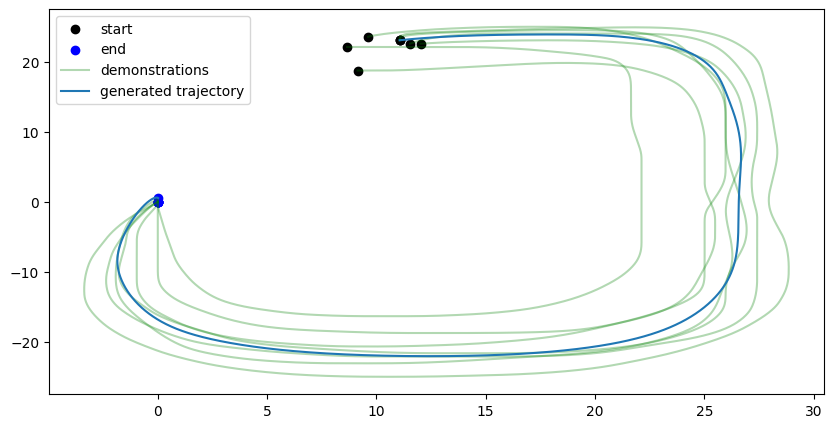

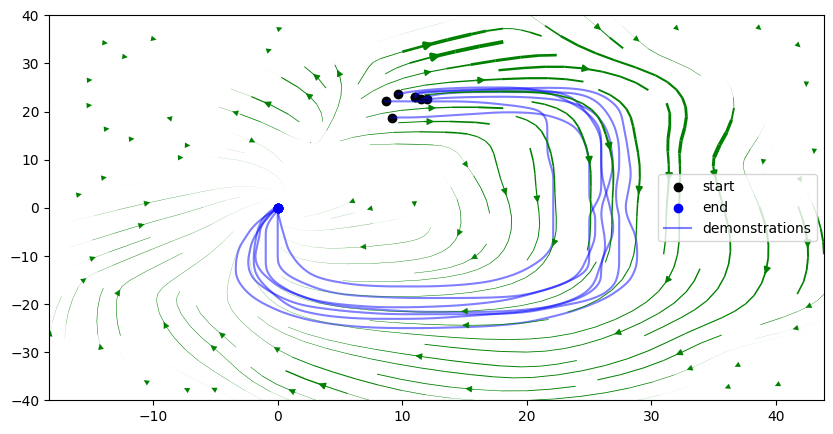

In [48]:
#fitting the model to data
model = LWR(mvns,False)
model.fit(x,xd)

#starting point for imitation
x0 = data[6][0]
x_rk4,t_tk4 = model.imitate(x0,t_end=10)

#plots for generated trajectory
plt.figure(figsize=(10,5))
plot_curves(data,alpha=0.3,c="g",label="demonstrations")
plot_curves(x_rk4[None],show_start_end=False,label="generated trajectory")

#vector field plot using stream line
plt.figure(figsize=(10,5))
plot_curves(data,alpha=0.5,c="b",label="demonstrations")

streamplot(model.predict,x_axis=(min(x[:,0])-15,max(x[:,0])+15),y_axis=(min(x[:,1])-15,max(x[:,1])+15),width=3,color="g")

#Fit the model to each of the data set and answer the following questions:

**For "C" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans: 
This system is not globally asymptotically stable because the vector field does not point toward the equilibrium everywhere. While trajectories near the equilibrium converge (indicating local stability), global convergence from all initial conditions is not guaranteed.

Q2.Try different initial points, and simulate the process.

**For "J" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:
The flow field shows large rotational motion and drift across the plane. Trajectories bend and circulate rather than converging to a single equilibrium from all initial conditions. Since global attractivity is missing, the system is not globally asymptotically stable.
Q2.Try different initial points, and simulate the process.

**For "S" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:
The vector field does not globally point toward a single equilibrium, and trajectories do not converge to one fixed point from all initial conditions. There is large-scale drift and circulation, so global attractivity is violated.
Q2.Try different initial points, and simulate the process.

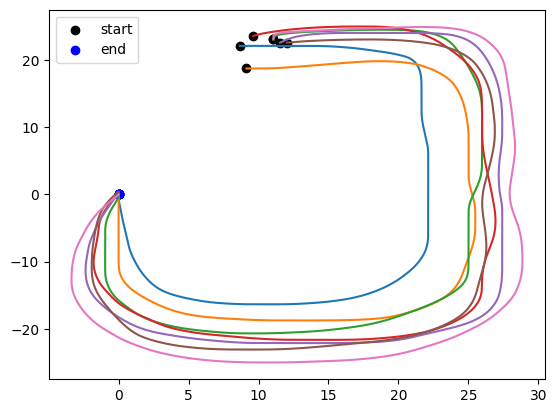

In [44]:
data,x,xd = load_data("j")

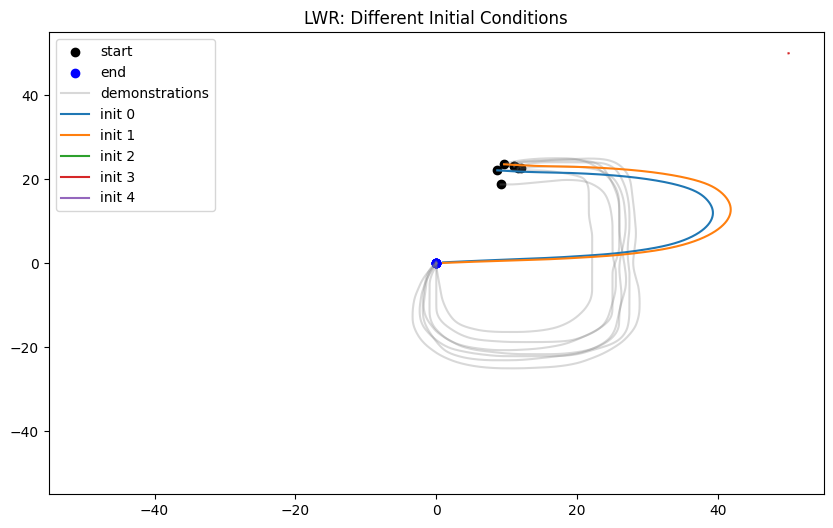

In [45]:
# Try multiple new starting points (inside and outside training region)
initial_points = [
    data[0][0],                  # original demo start
    data[3][0],                  # another demo start
    np.array([0, 0]),            # center point
    np.array([50, 50]),          # far outside region
    np.array([-50, -50])         # far outside region
]

plt.figure(figsize=(10,6))
plot_curves(data, alpha=0.3, c="gray", label="demonstrations")

for i, x0 in enumerate(initial_points):
    x_sim, _ = model.imitate(x0, t_end=10)
    plt.plot(x_sim[:,0], x_sim[:,1], label=f"init {i}")

plt.legend()
plt.title("LWR: Different Initial Conditions")
plt.show()

***for "S" Dataset*** \\
Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans: 
<br><br>
When using a small number of Gaussians (e.g., 2), the model is too coarse. 
The generated trajectory is overly smooth and cannot capture the fine 
curvature of the "S" shape. This is underfitting.

With a moderate number of Gaussians (e.g., 5–10), the model captures the 
shape well and generalizes smoothly. This gives the best balance between 
accuracy and stability.

With too many Gaussians (e.g., 20), the model becomes very locally sensitive. 
It fits the demonstrations very closely but may become unstable or 
overfit to noise. Generalization outside the training region worsens.

Therefore, increasing the number of Gaussians increases model flexibility, 
but too many components can reduce smooth generalization and stability.


Number of Gaussians: 2


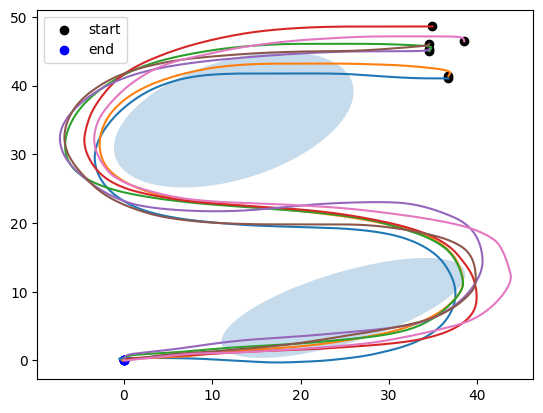

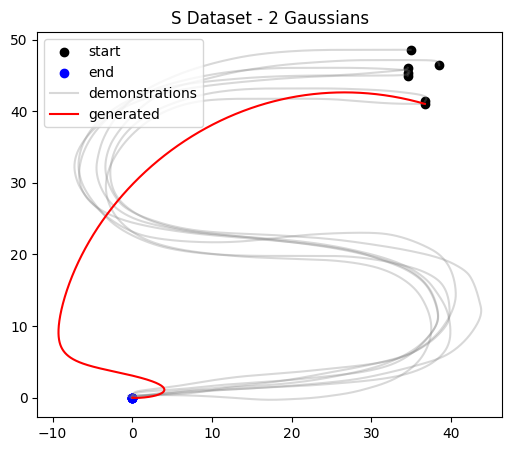


Number of Gaussians: 5


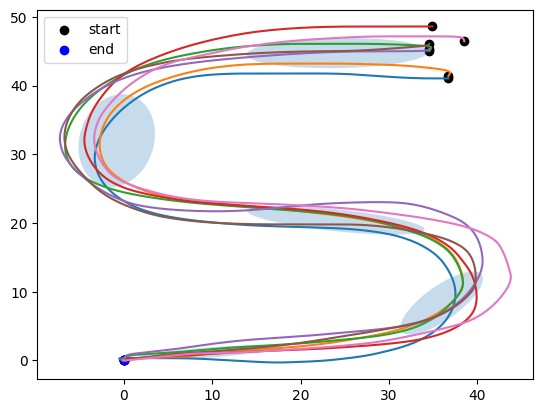

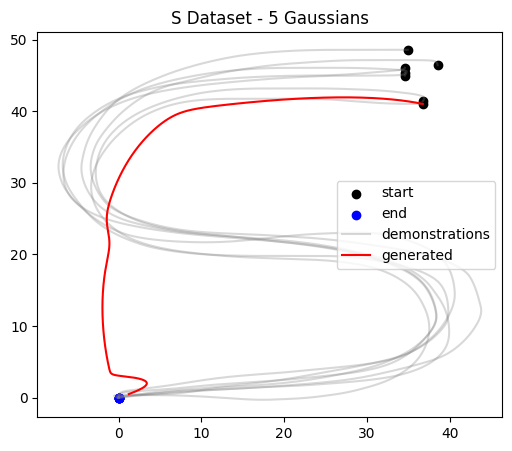


Number of Gaussians: 10


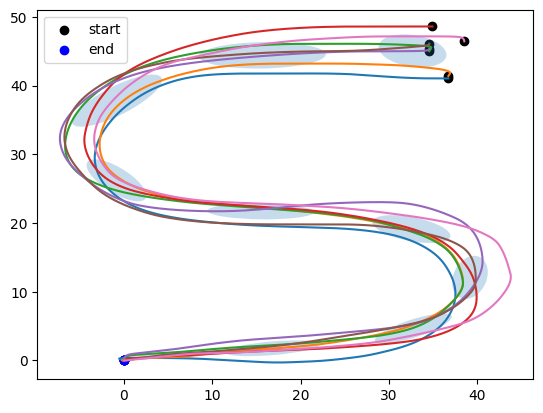

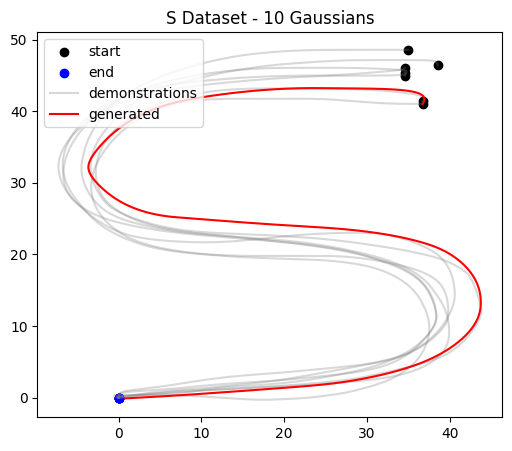


Number of Gaussians: 20


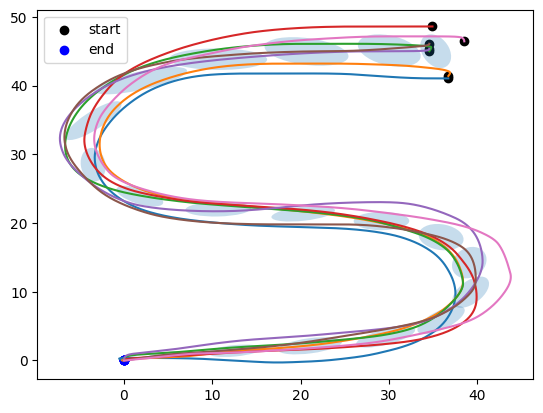

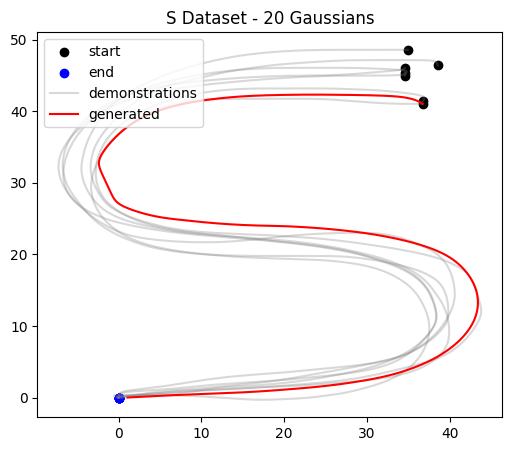

In [43]:
# Try different numbers of Gaussians
gaussian_numbers = [2, 5, 10, 20]

for n in gaussian_numbers:
    print(f"\nNumber of Gaussians: {n}")

    mvns = init_gaussians(data, n)
    model = LWR(mvns, bias=False)
    model.fit(x, xd)

    x0 = data[0][0]
    x_sim, _ = model.imitate(x0, t_end=10)

    plt.figure(figsize=(6,5))
    plot_curves(data, alpha=0.3, c="gray", label="demonstrations")
    plt.plot(x_sim[:,0], x_sim[:,1], c="r", label="generated")
    plt.title(f"S Dataset - {n} Gaussians")
    plt.legend()
    plt.show()

# LLS vs LWR

Q1.which one generalizes better? Why? \\
Ans:
<br><br>
LWR generalizes better within the demonstrated region because it models nonlinear dynamics using multiple locally weighted linear models. LLS is a single global linear model and cannot capture complex nonlinear shapes. However, LWR may extrapolate poorly outside the training region.

Q2.Does any one of the algorithms gives gaurentees of global attracter? \\
Ans:
<br>
<br>Only LLS can guarantee a global attractor if the system matrix has eigenvalues with strictly negative real parts (Hurwitz condition). LWR provides no global stability guarantees because it combines multiple local models into a nonlinear system.

# Submission details

please submit the copy of this file with the naming convention **SRNO(5digit)_Assignment3.ipynb**